In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

In [48]:
data_path = sample.data_path()

subjects_dir = data_path + '/subjects'
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname, preload=True)

raw.filter(2, 20)
events = mne.find_events(raw, 'STI 014')

# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')  # remove stim and EOG


Opening raw data file /home/user/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 993 samples (1.653 sec)

320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting metad

Number of events,123
Events,Auditory/Left: 56Visual/Left: 67
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


(376, 166800)


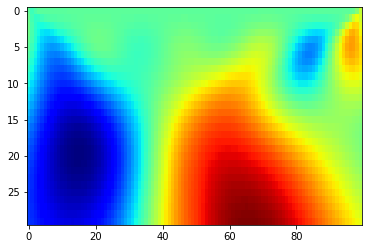

In [66]:
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
print(raw.get_data().shape)
from scipy import signal
data = raw.get_data()
cwtmatr = signal.cwt(data[10, 200:300], signal.ricker, np.arange(1, 31))

plt.imshow(cwtmatr, cmap='jet', aspect='auto')
plt.show()

In [67]:
y = epochs.events[:, 2]  # target: auditory left vs visual left
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression(solver='lbfgs'))

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)

[3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 3 1 3 1 3 1 3 1 1 3
 1 3 1 3 3 1 3 1 3 1 3 3 1 3 1 3 1 3 1 3 1 1 3 3 1 3 1 3 1 3 3 1 3 1 3 1 3
 1 3 3 3 1 3 3 3 3 1 3 1 3 1 1 3 1 3 1 3 1 3 1 3 3 1 3 3 1 3 3 1 3 1 3 3 3
 1 3 1 3 1 3 1 3 1 1 3 1]


In [16]:
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver='lbfgs')))
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=1)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

Spatio-temporal: 99.2%
Computing rank from data with rank=None
    Using tolerance 4.4e-11 (2.2e-16 eps * 203 dim * 9.7e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-11 (2.2e-16 eps * 203 dim * 1.1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-11 (2.2e-16 eps * 203 dim * 9.3e+02  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-11 (2.2e-16 eps

Computing rank from data with rank=None
    Using tolerance 4.8e-11 (2.2e-16 eps * 203 dim * 1.1e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-11 (2.2e-16 eps * 203 dim * 1.3e+03  max singular value)
    Estimated rank (mag): 203
    MAG: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.


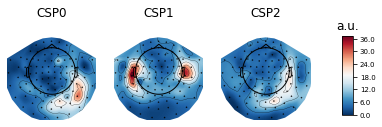

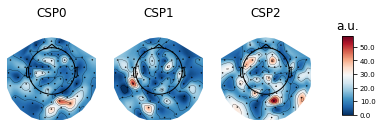

In [27]:
# Fit CSP on full data and plot
csp.fit(X, y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

In [28]:
# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)


No projector specified for this dataset. Please consider the method self.add_proj.


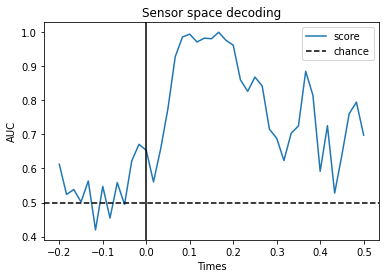

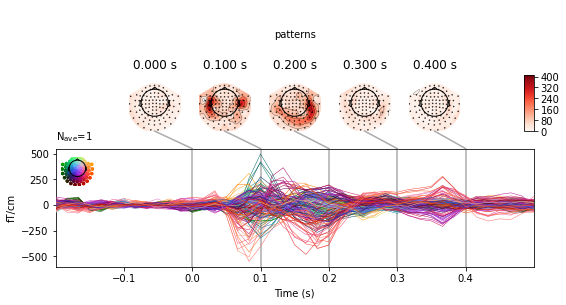

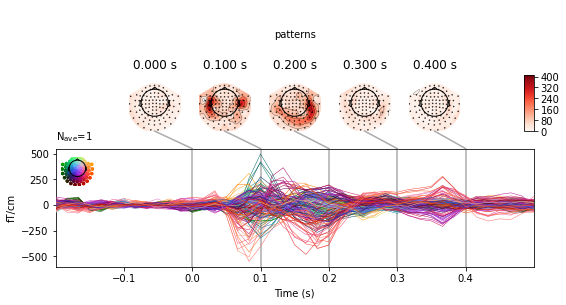

In [29]:
# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                           **joint_kwargs)

In [41]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose=True)
scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

Text(0.5, 1.0, 'Decoding MEG sensors over time')

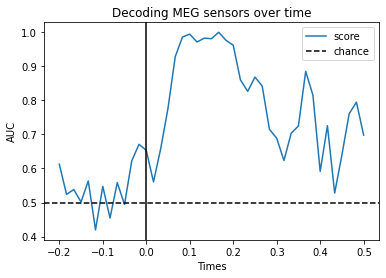

In [31]:
# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')

[[0.61245421 0.50999001 0.43687979 ... 0.52064602 0.52204462 0.43020313]
 [0.48448218 0.52384282 0.52810523 ... 0.61430236 0.53166833 0.49338994]
 [0.4958042  0.54741925 0.53804529 ... 0.63235098 0.59811855 0.57872128]
 ...
 [0.48344988 0.58178488 0.6017982  ... 0.76053946 0.79084249 0.66438561]
 [0.50914086 0.52815518 0.57880453 ... 0.81257076 0.79478854 0.66451881]
 [0.51120546 0.52920413 0.5518315  ... 0.72146187 0.6975691  0.6979354 ]]


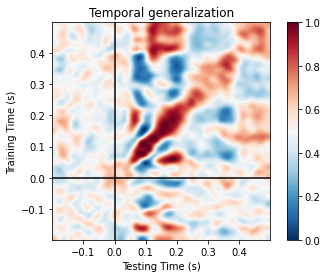

In [33]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

In [11]:
cov = mne.compute_covariance(epochs, tmax=0.)
del epochs
fwd = mne.read_forward_solution(
    data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif')
inv = mne.minimum_norm.make_inverse_operator(
    evoked_time_gen.info, fwd, cov, loose=0.)
stc = mne.minimum_norm.apply_inverse(evoked_time_gen, inv, 1. / 9., 'dSPM')
del fwd, inv

Computing rank from data with rank=None
    Using tolerance 3.4e-10 (2.2e-16 eps * 203 dim * 7.6e+03  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 1599
[done]
Reading forward solution from /home/user/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels,

In [12]:
brain = stc.plot(hemi='split', views=('lat', 'med'), initial_time=0.1,
                 subjects_dir=subjects_dir)




RuntimeError: Could not load any valid 3D backend: pyvista, mayavi, notebook